# Disease Type Classifier Evaluation

- BME 230A class project winter 2019
- Andrew E. Davidson
- [aedavids@ucsc.edu](mailto:aedavids@edu?subject=SimpleModel.ipynb)

ref: diseaseTypeClassifier.ipynb

identify genes that maximal activate and compare to known cancer causing genes

In [1]:
from keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import sys

import tensorflow as tf

# fix random seed for reproducibility
theMeaningOfLife = 42

import keras
if "2.1.6" != keras.__version__ :
    emsg = "ERROR keras version {} != 2.1.6, new version can not save and restore models".format(keras.__version__)
    raise ValueError(emsg)

# add path to our local modules
# assume they are in the same directory we launched the juypter server in
# /home/ubuntu/BME-230a
!pwd
localModuleDir = "."
sys.path.append(localModuleDir)

Using TensorFlow backend.


/home/ubuntu/BME-230a


## load model and data

In [2]:
%%time
rootDir = "/bme-230a-ebs"
sourceDataFilePath = "{}/data/tcga_target_gtex.h5".format(rootDir)
print(sourceDataFilePath)
if not os.path.isfile(sourceDataFilePath):
    emsg = "ERROR: {} not found".format(sourceDataFilePath)
    print(emsg)
    print("change rootDir")
    sys.stdout.flush()  # force error message to print
    raise ValueError(emsg)

from loadData import loadCancerDiseaseTypeTidyDataSet

ret = loadCancerDiseaseTypeTidyDataSet(rootDir)
hugoIds, diseaseLabelEncoder, XTrainNumpy, yTrainNumpy, XTestNumpy, yTestNumpy = ret
#XTestNumpy = yTestNumpy = None # clean up memory
ret = None  # clean up memory

/bme-230a-ebs/data/tcga_target_gtex.h5
sourceDataFilePath:/bme-230a-ebs/data/tcga_target_gtex.h5
CPU times: user 1.37 s, sys: 4.93 s, total: 6.3 s
Wall time: 6.3 s


## <span style="color:red"> AEDWIP the data looks suprisingly clean</span>
- was there a bug in the original data set prepration ?
- was a bug introduced while creating the tidy data set?
    * maybe sklearn.model_selection.StratifiedShuffleSplit samples with replacement by default?
- signifigant figure?

In [3]:
print(XTrainNumpy[0:10, 0:3])

[[-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]]


In [4]:
modelName="diseaseClassifier"
modelRootDir = "{}/models".format(rootDir)
fullModelPath = "{}/{}.h5".format(modelRootDir, modelName)
diseaseClassifierModel = load_model(fullModelPath)
diseaseClassifierModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 58581)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 58581)             234324    
_________________________________________________________________
dense_1 (Dense)              (None, 38)                2226116   
_________________________________________________________________
activation_1 (Activation)    (None, 38)                0         
Total params: 2,460,440
Trainable params: 2,343,278
Non-trainable params: 117,162
_________________________________________________________________


## Identify what disease type a given gene contributes the most to
It is often difficult to understand how neural networks work. One approach is given a trained model make predictions with hand crafted example. You can than explore the correspond activation at each layer. [Andrej Karpath](https://cs.stanford.edu/people/karpathy/) used a similar approach to identify what kinds of images cause the filters of a convolutional neural network to activate.

In [5]:
%%time
# find which class a gene maximal activates
def largestActivation(model, m, batchSize):
    '''
    for each featue calculates the disease type the feature makes the largest contribution to
    
    input:
        model:
        m: the number of features
        batchSize
        
    returns:
        numpy array of size (m,1).
        array[i] is the disease value of the gene at position i in the feature set
    '''
    ret = np.zeros((m, 1))
    numBatches, r = divmod(m, batchSize)
    print("m:{} batchSize:{} numBatches:{} r:{}".format(
        m, batchSize, numBatches, r))
    startRowIdx = 0
    batchCount = 0
    while (batchCount < numBatches):
        if batchCount < numBatches:
            bs = batchSize
        else:
            bs = r  # short batch

        # create a feature vector one hot. We only want the activation f
        # value for a single gene
        batch = np.zeros((bs, m))
        for j in range(bs):
            # use a high value
            # when value was 1 all predictions where class 27
            batch[j, startRowIdx + j] = 1000000

        predictions = model.predict(batch)
        predictedValuesTensor = keras.backend.argmax(predictions)

        # use keras escape hatch to tensor flow
        # there is probably a better way to do this
        sess = tf.Session()
        with sess.as_default():
            predictedValuesNumpy = predictedValuesTensor.eval()

        shape = predictedValuesNumpy.shape
        ret[startRowIdx:startRowIdx + bs] = np.reshape(predictedValuesNumpy,
                                                       (shape[0], -1))

        # increment loop counts
        batchCount += 1
        startRowIdx += bs

    return ret


# why hold on to all the memory we can probably pick these values out of the mode
xShape = XTrainNumpy.shape
maxActivations = largestActivation(
    diseaseClassifierModel, m=xShape[1], batchSize=6000)
print("maxActivations.shape:{}".format(maxActivations.shape))

m:58581 batchSize:6000 numBatches:9 r:4581
maxActivations.shape:(58581, 1)
CPU times: user 1min 22s, sys: 12.1 s, total: 1min 34s
Wall time: 27.2 s


In [6]:
%%capture --no-display
# turn off deprecation warnings
# https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=capture#cellmagic-capture
disease = diseaseLabelEncoder.inverse_transform(maxActivations.astype(int))

In [7]:
dataDict = {
    "HugoId": hugoIds,
    "disease": disease.flatten(),
    "maxActDisease": maxActivations.astype(int).flatten()
}

activationDF = pd.DataFrame(data=dataDict)
activationDF.head()

,HugoId,disease,maxActDisease
0,5S_rRNA,Ovarian Serous Cystadenocarcinoma,23
1,5_8S_rRNA,Kidney Clear Cell Carcinoma,16
2,7SK,Breast Invasive Carcinoma,6
3,A1BG,Lung Squamous Cell Carcinoma,20
4,A1BG-AS1,Breast Invasive Carcinoma,6


In [8]:
%%capture --no-display
# turn off deprecation warnings
# https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=capture#cellmagic-capture
countsDict = dict()
grouped = activationDF.groupby("maxActDisease")
for diseaseValue, group in grouped:
    stats = group.agg(['count'])
    dv = int(diseaseValue)
    key = "{}_{}".format(dv, diseaseLabelEncoder.inverse_transform([dv]))
    countsDict[key] = stats.values

In [9]:
print("key:24_['Pancreatic Adenocarcinoma'] maximal activated gene count:{}"
         .format(countsDict["24_['Pancreatic Adenocarcinoma']"]))

key:24_['Pancreatic Adenocarcinoma'] maximal activated gene count:[[44 44 44]]


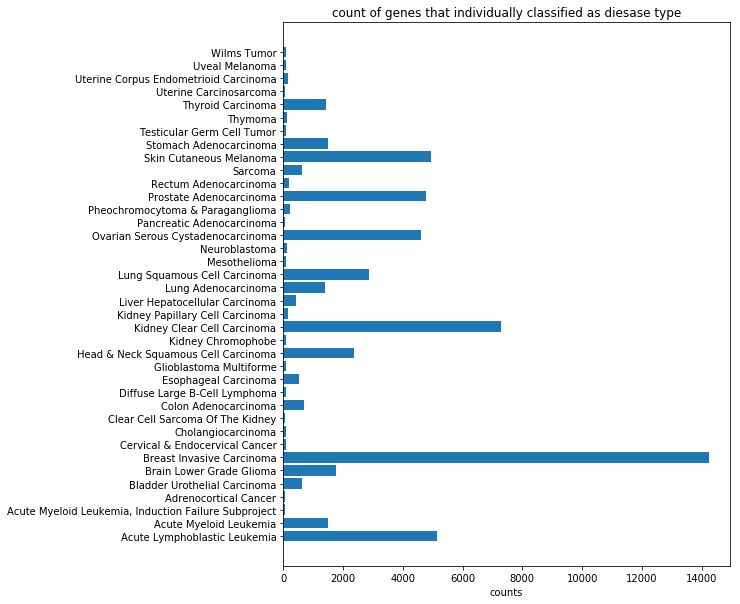

In [10]:
%%capture --no-display
# turn off deprecation warnings
# https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=capture#cellmagic-capture

fig, ax = plt.subplots()
fig.set_size_inches(8, 10)
countsList = [v[0][0] for v in countsDict.values()]
# AEDWIP no magic number 38 = number of classes
dt = diseaseLabelEncoder.inverse_transform(range(38))
plt.barh(dt, countsList)
plt.title("count of genes that individually classified as diesase type")
plt.xlabel("counts")
plt.show()

In [11]:
# find disease with fewest genes that individually classified as diesase type
# this is ugly. could not figure out how to do this using pandas
from math import inf
smallest = (inf, "AEDWIP")
for k, vv in countsDict.items():
    v = vv[0][0]
    if smallest[0] > v:
        smallest = (v, k)

print(smallest)

(44, "24_['Pancreatic Adenocarcinoma']")


In [12]:
#https://www.tutorialspoint.com/python_pandas/python_pandas_groupby.htm
groupedDF = activationDF.groupby('disease')
groupedDF.get_group('Pancreatic Adenocarcinoma')

,HugoId,disease,maxActDisease
2835,AC079235.1,Pancreatic Adenocarcinoma,24
2993,AC087499.9,Pancreatic Adenocarcinoma,24
3021,AC090311.1,Pancreatic Adenocarcinoma,24
4291,AC231645.1,Pancreatic Adenocarcinoma,24
5069,AL008708.1,Pancreatic Adenocarcinoma,24
5533,AL354931.1,Pancreatic Adenocarcinoma,24
5819,AL603650.4,Pancreatic Adenocarcinoma,24
6785,ARAF,Pancreatic Adenocarcinoma,24
7334,ATP6V1D,Pancreatic Adenocarcinoma,24
8132,C14orf93,Pancreatic Adenocarcinoma,24


https://www.kegg.jp/kegg-bin/search?q=%09Pancreatic+Adenocarcinoma&display=disease&from=disease
https://www.kegg.jp/dbget-bin/www_bget?ds:H00019

        
google CYB5D2 Pancreatic Adenocarcinoma
https://www.proteinatlas.org/ENSG00000167740-CYB5D2/pathology
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4753160/